In [15]:
import torch
from torch import nn
from torch.nn import functional as F
from models.nets import MLP
import pylab as pl
import wandb
from IPython.display import clear_output

from utils.train import basic_train

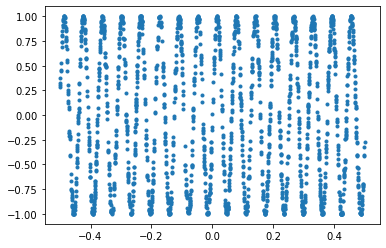

In [2]:
# Generate data
def f(x):
    return torch.sin(100*x)# + 0.1*torch.randn((N, ))
N = 2048
x = torch.rand((N, )) - 0.5
y = f(x)
x_test = 2 * x
y_test = f(x_test)

pl.plot(x, y, '.')
pl.show()

In [ ]:
def train():
    with wandb.init(project="NN-tests", entity="lettera") as run:
        config = wandb.config
        print(config)
        net = MLP.MLP(1, 1, hidden_size=config["hidden_size"], mlp_blocks=config["skip_mlps"], dropout=config["dropout"], skip=True, activation=nn.ReLU())
        net.train()
        optimizer = torch.optim.Adam(net.parameters(), config["learning_rate"], weight_decay=config["weight_decay"])
        criterion = nn.MSELoss()
        for epoch in range(300):
            y_pred = net(x.view(-1, 1))
            loss = criterion(y_pred.ravel(), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            wandb.log({"loss": loss, "epoch": epoch})
        
        with torch.no_grad():
            net.eval()
            y_pred = net(x_test.view(-1, 1))
            loss = criterion(y_pred.ravel(), y_test)
            wandb.log({"eval_loss": loss})

count = 50 # number of runs to execute
wandb.agent("lettera/NN-tests/map2sfmv", function=train, count=count)

In [3]:
%matplotlib inline

In [4]:
net = MLP.MLP(1, 1, hidden_size=64, mlp_blocks=5, dropout=0, skip=False, activation=nn.Mish())

In [13]:
from sklearn.datasets import load_digits
digits = load_digits()
x, y = digits.data, digits.target
# data to torch
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).long()

# Split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
# Random forest classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
model = RandomForestClassifier(n_estimators=500, random_state=42).fit(x_train, y_train)

log_loss(y_test, model.predict_proba(x_test))

0.2818823507377205

In [ ]:
0.02615383267402649

Epoch 1990/2000 eval loss: 0.02272154949605465


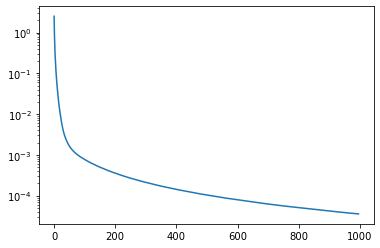

In [134]:
net = MLP.MLP(64, 10, hidden_size=256, mlp_blocks=5, dropout=0, skip=False, activation=nn.Mish())
adversary = MLP.MLP(64, 64, hidden_size=128, mlp_blocks=5, dropout=0, skip=False, activation=nn.Mish())

optimizer = torch.optim.Adam(net.parameters(), 1e-3)
adv_optimizer = torch.optim.Adam(adversary.parameters(), 1e-3)
criterion = nn.CrossEntropyLoss()
losses = []
epochs = 2000
for epoch in range(epochs):
    if epoch % 2 == 0:
        # Train normal net
        net.train()
        x = x_train + torch.tanh(adversary(x_train)) * torch.rand((1, )) * 1e-3
        y_pred = net(x)
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    else:
        # Adversarial step
        net.train()
        x = x_train + torch.tanh(adversary(x_train)) * torch.rand((1, )) * 1e-3
        y_pred = net(x)
        adverial_loss = -criterion(y_pred, y_train)
        adv_optimizer.zero_grad()
        adverial_loss.backward()
        adv_optimizer.step()

    if epoch % 10 == 0:
        net.eval()
        clear_output(True)
        print(f"Epoch {epoch}/{epochs} eval loss: {criterion(net(x_test), y_test)}")
        pl.plot(losses)
        pl.yscale("log")
        pl.show()

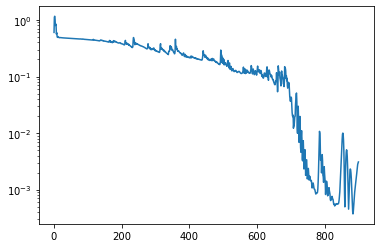

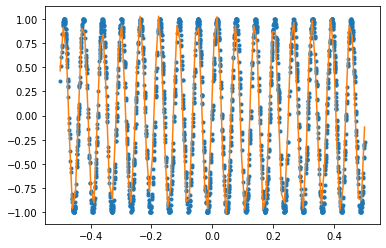

In [50]:
# Train loop
from IPython.display import clear_output

optimizer = torch.optim.Adam(net.parameters(), 1e-2)
criterion = nn.MSELoss()
losses = []
epochs = 1000
for epoch in range(epochs):
    net.train()
    y_pred = net(x.view(-1, 1))
    loss = criterion(y_pred.ravel(), y)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        net.eval()
        clear_output(True)
        pl.plot(losses)
        pl.yscale("log")
        pl.show()
        pl.plot(x, y, '.')
        t = torch.linspace(-0.5, 0.5, 100)
        pl.plot(t, net(t.view(-1, 1)).ravel().detach())
        pl.show()
        

In [51]:
from sklearn.decomposition import PCA

t = torch.linspace(-0.5, 0.5, 1024).view(-1, 1)
for i, module in enumerate(net.children()):
    t = module(t)
    print(t.shape)
    if min(t.shape) < 8:
        continue
    pca = PCA(n_components=8).fit(t.detach().cpu().numpy())

    print(pca.explained_variance_ratio_)

torch.Size([1024, 64])
[1.0000002e+00 2.7518089e-13 3.0690129e-16 2.7144023e-16 1.4937348e-16
 1.2248173e-16 1.1635725e-16 8.3350378e-17]
torch.Size([1024, 64])
[0.24203236 0.19556795 0.11222056 0.06914933 0.06639007 0.05967978
 0.03760414 0.03543098]
torch.Size([1024, 1])


In [108]:
%matplotlib qt

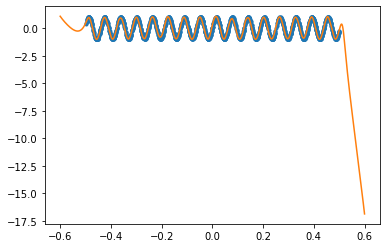

In [54]:
net.eval()
pl.plot(x, y, '.')
t = torch.linspace(-0.5, 0.5, 4096) * 1.2
pl.plot(t, net(t.view(-1, 1)).ravel().detach())
pl.show()